In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Projet-ML')

In [ ]:
%cd gdrive/My Drive/Projet-ML

/content/gdrive/My Drive/Projet-ML


In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyoff
import xgboost as xgb
import seaborn as sns
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

In [ ]:
import warnings  # Des warnings qui me fatiguent
warnings.filterwarnings("ignore")

In [ ]:
!pip install common

  Created wheel for common: filename=common-0.1.2-cp36-none-any.whl size=3734 sha256=61ab41161fd323c3a1f5440973122ea90677d788ee8e1f78b778b4cf8d067392
  Stored in directory: /root/.cache/pip/wheels/2e/8f/ec/9ac55fd8f7923ddf23619c89b42dbbcfc71db6ee41ad5e7b5e
Successfully built common


In [ ]:
df = pd.read_csv('data/df_condition.csv')

In [ ]:
df

,Unnamed: 0,Stn Id,Stn Name,CIMIS Region,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,0,2,FivePoints,San Joaquin Valley,1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0.0
1,1,2,FivePoints,San Joaquin Valley,1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0.0
2,2,2,FivePoints,San Joaquin Valley,1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0.0
3,3,2,FivePoints,San Joaquin Valley,1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0.0
4,4,2,FivePoints,San Joaquin Valley,1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69775,81019,2,FivePoints,San Joaquin Valley,8/22/2019,0.25,0.00,618.0,17.0,95.5,62.2,79.1,71.0,30.0,50.0,58.9,4.4,106.2,75.7,0.0
69776,81020,2,FivePoints,San Joaquin Valley,8/23/2019,0.25,0.00,610.0,18.0,98.2,66.4,83.4,75.0,29.0,46.0,60.5,3.8,91.3,76.7,0.0
69777,81021,2,FivePoints,San Joaquin Valley,8/24/2019,0.27,0.00,601.0,17.8,98.0,66.8,83.0,70.0,30.0,46.0,60.2,5.4,128.4,77.5,0.0
69778,81022,2,FivePoints,San Joaquin Valley,8/25/2019,0.26,0.00,551.0,16.3,99.0,68.3,84.7,61.0,27.0,40.0,57.8,5.2,125.7,77.8,0.0


In [ ]:
df=df.rename(columns ={'CIMIS Region':'Region', 'Stn Name':'Name'})
df=df[df.Name == 'Bishop']

In [ ]:
ligne_9sept = df.iloc[8]
ligne_9sept['Date']='1/9/2018'
ligne_31mars=df.iloc[87]
ligne_31mars['Date']='3/31/2018'

In [ ]:
df=df.append(ligne_9sept)
df=df.append(ligne_31mars)

In [ ]:
df2=pd.DataFrame()

## TRAITEMENT DES DONNEES

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df=df.sort_values(by='Date')
df.set_index('Date', inplace=True)
df = df.rename_axis(None)

In [ ]:
df.drop(['Unnamed: 0', 'Stn Id','Target','Name','Region'], axis=1, inplace=True)

In [ ]:
df=df.dropna()
df

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F)
2018-01-01,0.07,0.0,249.0,3.0,66.7,21.9,41.1,67.0,12.0,34.0,15.0,2.3,56.2,42.2
2018-01-02,0.04,0.0,138.0,3.7,61.2,27.5,41.9,64.0,17.0,41.0,19.8,2.2,52.8,42.7
2018-01-03,0.07,0.0,209.0,4.0,63.2,25.4,44.2,72.0,20.0,40.0,21.7,2.4,58.2,43.0
2018-01-04,0.06,0.0,220.0,4.0,63.1,25.4,41.2,73.0,21.0,46.0,21.8,2.6,61.3,43.9
2018-01-05,0.06,0.0,272.0,4.8,63.4,26.0,43.9,80.0,27.0,49.0,26.0,2.3,54.8,43.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,0.28,0.0,779.0,7.4,86.4,44.4,68.8,76.0,15.0,31.0,36.7,3.2,76.0,70.8
2019-06-27,0.27,0.0,780.0,6.3,88.1,39.4,66.7,71.0,14.0,28.0,32.7,2.2,51.8,70.4
2019-06-28,0.30,0.0,748.0,6.6,87.8,41.8,68.8,78.0,13.0,27.0,33.9,3.7,89.9,70.1
2019-06-29,0.28,0.0,773.0,7.6,88.3,43.7,69.8,76.0,16.0,30.0,37.3,2.9,69.2,70.6


## AUTO-ARIMA

In [ ]:
pip install pandas_bokeh

In [ ]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

In [ ]:
df['Avg Rel Hum (%)'].dropna().plot(figsize=(800,250),legend='top_left')

Figure(id='1001', ...)

In [ ]:
data=pd.DataFrame(df['Avg Rel Hum (%)'])
data.columns

Index(['Avg Rel Hum (%)'], dtype='object')

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.088756
p-value: 0.001011


In [ ]:
data.dropna().plot(figsize=(800,250),legend='top_left')

Figure(id='1202', ...)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive')
result.plot()

ValueError: ignored

In [ ]:
!python3 -m pip install pmdarima --user
!python3 -m pip install statsmodels --upgrade

  Using cached https://files.pythonhosted.org/packages/cb/83/540fd83238a18abe6c2d280fa8e489ac5fcefa1f370f0ca1acd16ae1b860/statsmodels-0.11.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: sktime 0.4.2 has requirement statsmodels>=0.12.0, but you'll have statsmodels 0.11.1 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/00/93/1b6882f92d94e491a3e3be101fc83934551eada261281980f3957246432f/statsmodels-0.12.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: pmdarima 1.7.1 has requirement statsmodels<0.12,>=0.11, but you'll have statsmodels 0.12.0 which is incompatible.
  Found existing installation: statsmodels 0.11.1
    Uninstalling statsmodels-0.11.1:
      Successfully uninstalled statsmodels-0.11.1


In [ ]:
!pip install --ignore-installed --no-cache scipy==1.2.2 
from pmdarima.arima import auto_arima

     |████████████████████████████████| 24.8MB 1.2MB/s 
     |████████████████████████████████| 14.5MB 67.0MB/s 
ERROR: pmdarima 1.7.1 has requirement scipy>=1.3.2, but you'll have scipy 1.2.2 which is incompatible.
ERROR: pmdarima 1.7.1 has requirement statsmodels<0.12,>=0.11, but you'll have statsmodels 0.12.0 which is incompatible.
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.2.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-603.093, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-810.858, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-668.258, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-863.741, Time=0.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-804.439, Time=0.49 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-897.768, Time=1.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-843.787, Time=0.74 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-920.807, Time=1.64 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-865.

In [ ]:
stepwise_model.aic()

-920.806897702827

In [ ]:
stepwise_model.seasonal_order 

(2, 1, 0, 12)

In [ ]:
train = data.loc['2018-01-01':'2019-04-23']

In [ ]:
train.tail()

2019-04-19    0.00
2019-04-20    0.00
2019-04-21    0.00
2019-04-22    0.00
2019-04-23    0.07
Name: Precip (in), dtype: float64

In [ ]:
test=data.loc['2019-04-24':]

In [ ]:
test.head()

2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
Name: Precip (in), dtype: float64

In [ ]:
test.tail()

2019-08-22    0.0
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
Name: Precip (in), dtype: float64

In [ ]:
len(test)

125

In [ ]:
stepwise_model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
future_forecast, ci = stepwise_model.predict(n_periods=125, return_conf_int=True,alpha=0.05)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=125)

In [ ]:
future_forecast

array([0.06376421, 0.21641499, 0.05327268, 0.10872067, 0.12123712,
       0.03640822, 0.03491328, 0.03618227, 0.04278285, 0.03638117,
       0.03605229, 0.06340044, 0.06107011, 0.12052198, 0.05694286,
       0.13946069, 0.14733779, 0.05039341, 0.04980523, 0.05029609,
       0.05286752, 0.05037662, 0.05024823, 0.08181687, 0.07904577,
       0.1478173 , 0.07430351, 0.15729869, 0.16722407, 0.06671299,
       0.06603721, 0.06660759, 0.06958151, 0.06669837, 0.0665501 ,
       0.10883833, 0.10511884, 0.19725435, 0.09876806, 0.17303278,
       0.18315377, 0.08859753, 0.08769256, 0.08845697, 0.09244121,
       0.08857839, 0.08837976, 0.12280678, 0.1198038 , 0.19476767,
       0.11462692, 0.19407372, 0.20343672, 0.10635632, 0.1056186 ,
       0.10623975, 0.1094816 , 0.10633926, 0.10617758, 0.1420629 ,
       0.13891807, 0.2170834 , 0.13352586, 0.21253014, 0.222295  ,
       0.12489946, 0.12413106, 0.1247792 , 0.12815939, 0.12488254,
       0.12471399, 0.16215959, 0.158878  , 0.24044173, 0.15325

In [ ]:
len(future_forecast)

125

In [ ]:
test.mean()

0.01576

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [ ]:
future_forecast_ci = pd.DataFrame(ci, index=test.index, columns = ['lwb', 'ub'])

In [ ]:
pd.concat([test,future_forecast],axis=1).plot(colormap=('blue', 'orange'))

Figure(id='1802', ...)

In [ ]:
future_forecast2 = future_forecast

In [ ]:
future_forecast2=pd.Series(future_forecast2["Prediction"],index=future_forecast2.index)

In [ ]:
out = pd.concat([data,future_forecast2],axis=1).plot(
    colormap=('blue', 'green'), legend = "bottom_right")


In [ ]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
!python3 -m pip install sktime --upgrade
from sktime.performance_metrics.forecasting import smape_loss
smape_perso(future_forecast2,test)

     |████████████████████████████████| 5.6MB 3.9MB/s 
     |████████████████████████████████| 6.8MB 23.4MB/s 
ERROR: pmdarima 1.7.1 has requirement statsmodels<0.12,>=0.11, but you'll have statsmodels 0.12.0 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


193.1866947401144

## AUTO-ARIMA 2

In [ ]:
df.tail(3)

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F)
2019-06-28,0.30,0.0,748.0,6.6,87.8,41.8,68.8,78.0,13.0,27.0,33.9,3.7,89.9,70.1
2019-06-29,0.28,0.0,773.0,7.6,88.3,43.7,69.8,76.0,16.0,30.0,37.3,2.9,69.2,70.6
2019-06-30,0.27,0.0,759.0,8.8,89.7,44.8,71.2,79.0,18.0,34.0,41.1,2.1,51.6,70.9


In [ ]:
step=-1
df['hum_actuel']=df['Avg Rel Hum (%)'].shift(step)
df.tail(3)

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),hum_actuel
2019-06-28,0.30,0.0,748.0,6.6,87.8,41.8,68.8,78.0,13.0,27.0,33.9,3.7,89.9,70.1,30.0
2019-06-29,0.28,0.0,773.0,7.6,88.3,43.7,69.8,76.0,16.0,30.0,37.3,2.9,69.2,70.6,34.0
2019-06-30,0.27,0.0,759.0,8.8,89.7,44.8,71.2,79.0,18.0,34.0,41.1,2.1,51.6,70.9,NaN


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0,1))
scaled_input = sc_in.fit_transform(df[['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)',
       'Max Air Temp (F)', 'Min Air Temp (F)', 'Avg Air Temp (F)',
       'Max Rel Hum (%)', 'Min Rel Hum (%)', 'Avg Rel Hum (%)',
       'Dew Point (F)', 'Avg Wind Speed (mph)', 'Wind Run (miles)',
       'Avg Soil Temp (F)']])
scaled_input= pd.DataFrame(scaled_input)
X = scaled_input
#X.rename(columns={0:'pickups',1:'temp'}, inplace = True)
X.columns = ['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)',
       'Max Air Temp (F)', 'Min Air Temp (F)', 'Avg Air Temp (F)',
       'Max Rel Hum (%)', 'Min Rel Hum (%)', 'Avg Rel Hum (%)',
       'Dew Point (F)', 'Avg Wind Speed (mph)', 'Wind Run (miles)',
       'Avg Soil Temp (F)']
X

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F)
0,0.21875,0.0,0.279255,0.169492,0.436202,0.224863,0.255396,0.67,0.153846,0.354167,0.637973,0.090909,0.096392,0.090674
1,0.12500,0.0,0.131649,0.209040,0.354599,0.327239,0.269784,0.64,0.217949,0.427083,0.676589,0.077922,0.078083,0.103627
2,0.21875,0.0,0.226064,0.225989,0.384273,0.288848,0.311151,0.72,0.256410,0.416667,0.691874,0.103896,0.107162,0.111399
3,0.18750,0.0,0.240691,0.225989,0.382789,0.288848,0.257194,0.73,0.269231,0.479167,0.692679,0.129870,0.123856,0.134715
4,0.18750,0.0,0.309840,0.271186,0.387240,0.299817,0.305755,0.80,0.346154,0.510417,0.726468,0.090909,0.088853,0.134715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.87500,0.0,0.984043,0.418079,0.728487,0.636197,0.753597,0.76,0.192308,0.322917,0.812550,0.207792,0.203016,0.831606
516,0.84375,0.0,0.985372,0.355932,0.753709,0.544790,0.715827,0.71,0.179487,0.291667,0.780370,0.077922,0.072698,0.821244
517,0.93750,0.0,0.942819,0.372881,0.749258,0.588665,0.753597,0.78,0.166667,0.281250,0.790024,0.272727,0.277868,0.813472
518,0.87500,0.0,0.976064,0.429379,0.756677,0.623400,0.771583,0.76,0.205128,0.312500,0.817377,0.168831,0.166397,0.826425


In [ ]:
sc_out = MinMaxScaler(feature_range=(0,1))
scaler_output = sc_out.fit_transform(df[['hum_actuel']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y.rename(columns={0:'hum_day_after'}, inplace = True)
y

,hum_day_after
0,0.427083
1,0.416667
2,0.479167
3,0.510417
4,0.510417
...,...
515,0.291667
516,0.281250
517,0.312500
518,0.354167


In [ ]:
train_size = int(len(df)-30)
test_size = int(len(df)) - train_size

X_train, y_train = X[:train_size].dropna(), y[:train_size].dropna()
X_test, y_test = X[train_size:].dropna(), y[train_size:].dropna()
print(X_test.shape)

(30, 14)


In [ ]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'Valeur critique ({key})']=val
    if dftest[1]<=0.05:
        print("Preuves contre la null hypothesis")
        print("On rejette la null hypothesis - les données sont stationaire")
    else:
        print("Preuves pour la null hypothesis")
        print("On accept la null hypothesis - les données ne sont pas stationaire")

In [ ]:
test = y['hum_day_after'][:train_size].dropna()
test_adf(test,'hum_day_after')

Preuves contre la null hypothesis
On rejette la null hypothesis - les données sont stationaire


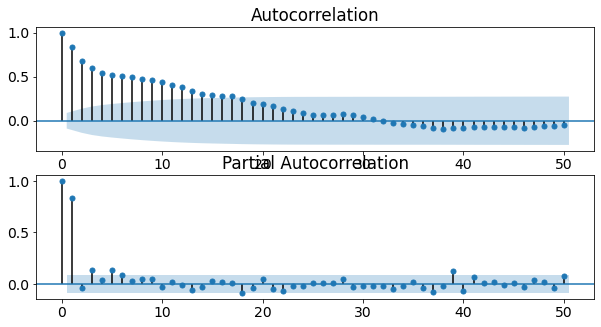

In [ ]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(test, lags=50, ax=ax[1])
plt.show()

In [ ]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
 exogenous= X_train,
 start_p=1, start_q=1, 
 max_p=5, max_q=5, 
 d=1,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-874.197, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-818.823, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-817.087, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-875.276, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-820.816, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-879.438, Time=2.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-870.736, Time=1.93 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-868.051, Time=1.99 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-868.581, Time=2.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-885.856, Time=1.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-885.374, Time=1.65 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-884.954, Time=2.01 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-883.919, Time=1.99 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-883.922, Time=1.91 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [ ]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  490
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 459.928
Date:                Tue, 20 Oct 2020   AIC                           -885.856
Time:                        15:16:21   BIC                           -814.586
Sample:                             0   HQIC                          -857.863
                                - 490                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
ETo (in)                 0.2481      0.144      1.719      0.086      -0.035       0.531
Precip (in)             -0.1091      0.038     -2.833      0.005      -0.185      -0.034
Sol Rad (Ly/day)        -0.1675      0.102     -1.645      0.100      -0.367       0.032
Avg Vap Pres (mBars)     0.0482      0.103      0.469      0.639      -0.153       0.250
Max Air Temp (F)        -0.2464      0.128     -1.928      0.054      -0.497       0.004
Min Air Temp (F)        -0.2080      0.089     -2.339      0.019      -0.382      -0.034
Avg Air Temp (F)         0.2240      0.210      1.069      0.285      -0.187       0.635
Max Rel Hum (%)         -0.1805      0.059     -3.061      0.002      -0.296      -0.065
Min Rel Hum (%)         -0.0034      0.092     -0.037      0.970      -0.185       0.178
Avg Rel Hum (%)          0.6842      0.168      4.082      0.000       0.356       1.013
Dew Point (F)            0.3622      0.112      3.240      0.001       0.143       0.581
Avg Wind Speed (mph)     0.3148      1.234      0.255      0.799      -2.103       2.733
Wind Run (miles)        -0.3940      1.235     -0.319      0.750      -2.814       2.026
Avg Soil Temp (F)       -0.1227      0.072     -1.700      0.089      -0.264       0.019
ma.L1                   -0.8811      0.069    -12.787      0.000      -1.016      -0.746
ma.L2                   -0.0965      0.063     -1.542      0.123      -0.219       0.026
sigma2                   0.0089      0.000     26.571      0.000       0.008       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               524.08
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(y_train, 
 exog=X_train,
 order=(0,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

In [ ]:
results = model.fit(maxiter=300)

In [ ]:
results.mle_retvals

{'converged': True,
 'fcalls': 3726,
 'fopt': -0.9315745836085854,
 'gopt': array([-1.58343116e-05, -7.21550042e-05,  1.58432933e-05,  5.38738498e-05,
        -1.37169276e-05,  1.25177868e-05, -1.16841203e-05, -8.88139562e-06,
         3.63655994e-05,  2.19876894e-05, -2.32565078e-05,  3.10298898e-05,
         2.98031488e-05,  2.48547405e-05,  4.03241662e-05,  2.67101119e-05,
        -1.76830406e-04]),
 'iterations': 175,
 'warnflag': 0}

In [ ]:
y_train.shape

(490, 1)

In [ ]:
predictions= results.predict(start=train_size, end=train_size+test_size+(step),exog=X_test)

In [ ]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [ ]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index
predictions['hum_actuel'] = act['hum_day_after']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
predictions

,Pred,hum_actuel
490,0.489095,0.541667
491,0.525137,0.479167
492,0.485189,0.416667
493,0.448462,0.427083
494,0.442513,0.395833
495,0.419221,0.333333
496,0.344363,0.250000
497,0.302477,0.354167
498,0.375706,0.375000
499,0.405528,0.343750


In [ ]:
out = pd.concat([predictions['hum_actuel'],predictions['Pred']],axis=1).plot(
    colormap=('blue', 'green'), legend = "bottom_right")


In [ ]:
forecast= results.forecast(steps=test_size, exog=X_test)

In [ ]:
forecast= pd.DataFrame(forecast)
forecast.reset_index(drop=True, inplace=True)
forecast.index=X_test.index
forecast['hum_actuel'] =scaler_output.iloc[train_size:, 0]
forecast.rename(columns={'predicted_mean':'Forecast'}, inplace=True)
forecast

,Forecast,hum_actuel
490,0.489095,0.541667
491,0.525137,0.479167
492,0.485189,0.416667
493,0.448462,0.427083
494,0.442513,0.395833
495,0.419221,0.333333
496,0.344363,0.250000
497,0.302477,0.354167
498,0.375706,0.375000
499,0.405528,0.343750


In [ ]:
y_test

,hum_day_after
490,0.541667
491,0.479167
492,0.416667
493,0.427083
494,0.395833
495,0.333333
496,0.250000
497,0.354167
498,0.375000
499,0.343750


In [ ]:
out = pd.concat([forecast['hum_actuel'],forecast['Forecast']],axis=1).plot(
    colormap=('blue', 'green'), legend = "bottom_right")

In [ ]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['hum_actuel']])

In [ ]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
evaluating = smape_perso(trainPredict[:-1], testPredict[:-1])
evaluating

13.998935106023554

## RNN Une feature, tableau dupliqué


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Projet-ML')

%cd gdrive/My Drive/Projet-ML

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyoff
import xgboost as xgb
import seaborn as sns
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

df = pd.read_csv('data/df_condition.csv')
df=df.rename(columns ={'CIMIS Region':'Region', 'Stn Name':'Name'})
df=df[df.Name == 'Bishop']
ligne_9sept = df.iloc[8]
ligne_9sept['Date']='1/9/2018'
ligne_31mars=df.iloc[87]
ligne_31mars['Date']='3/31/2018'
df=df.append(ligne_9sept)
df=df.append(ligne_31mars)

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df=df.sort_values(by='Date')
df.set_index('Date', inplace=True)
df = df.rename_axis(None)
df.drop(['Unnamed: 0', 'Stn Id','Target','Name','Region'], axis=1, inplace=True)
df=df.dropna()

In [ ]:
df

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F)
2018-01-01,0.07,0.0,249.0,3.0,66.7,21.9,41.1,67.0,12.0,34.0,15.0,2.3,56.2,42.2
2018-01-02,0.04,0.0,138.0,3.7,61.2,27.5,41.9,64.0,17.0,41.0,19.8,2.2,52.8,42.7
2018-01-03,0.07,0.0,209.0,4.0,63.2,25.4,44.2,72.0,20.0,40.0,21.7,2.4,58.2,43.0
2018-01-04,0.06,0.0,220.0,4.0,63.1,25.4,41.2,73.0,21.0,46.0,21.8,2.6,61.3,43.9
2018-01-05,0.06,0.0,272.0,4.8,63.4,26.0,43.9,80.0,27.0,49.0,26.0,2.3,54.8,43.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,0.28,0.0,779.0,7.4,86.4,44.4,68.8,76.0,15.0,31.0,36.7,3.2,76.0,70.8
2019-06-27,0.27,0.0,780.0,6.3,88.1,39.4,66.7,71.0,14.0,28.0,32.7,2.2,51.8,70.4
2019-06-28,0.30,0.0,748.0,6.6,87.8,41.8,68.8,78.0,13.0,27.0,33.9,3.7,89.9,70.1
2019-06-29,0.28,0.0,773.0,7.6,88.3,43.7,69.8,76.0,16.0,30.0,37.3,2.9,69.2,70.6


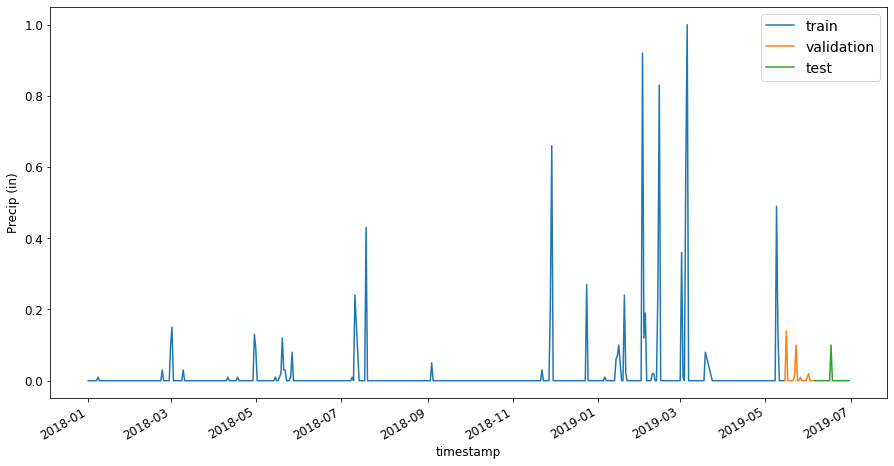

Epoch 1/10
15/15 [==============================] - 1s 35ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0014
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 5/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0015
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 8/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0014
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0014


In [ ]:
#Separation des données pour le test et pour le train
valid_start_dt = '2019-05-15'
test_start_dt = '2019-06-05'

T = 1
HORIZON = 1

# Create training dataset 
df[df.index < valid_start_dt][[col_target]].rename(columns={col_target:'train'}) \
  .join(df[(df.index >=valid_start_dt) & (df.index < test_start_dt)][[col_target]] \
          .rename(columns={col_target:'validation'}), how='outer') \
  .join(df[test_start_dt:][[col_target]].rename(columns={col_target:'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel(col_target, fontsize=12)
plt.show()

# 1. Get the train data from the correct data range
train = df.copy()[df.index < valid_start_dt][[col_target]]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train[col_target] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted[col_target].shift(-1, freq='d')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted[col_target].shift(T-t, freq='d')
y_col = 'y_t+1'
X_cols = [#col_target+' t-5',
          #col_target+' t-4',
          #col_target+' t-3',
          #col_target+' t-2',
          #col_target+' t-1',
          col_target+' t']
train_shifted.columns = [col_target+'_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[col_target]]

# 2. Scale the series using the transformer fitted on the training set:
valid[col_target] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted[col_target].shift(-1, freq='d')
for t in range(1, T+1):
    valid_shifted[col_target+'_t-'+str(T-t)] = valid_shifted[col_target].shift(T-t, freq='d')
  
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[[col_target+'_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

FIRST_LAYER_LATENT_DIM = 8 
SECOND_LAYER_LATENT_DIM = 6
BATCH_SIZE = 32 
EPOCHS = 10 

model = Sequential()
model.add(GRU(FIRST_LAYER_LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(SECOND_LAYER_LATENT_DIM))
model.add(Dense(HORIZON))

model.compile(optimizer='RMSprop', loss='mse')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
test = df.copy()[test_start_dt:][[col_target]]

# 2. Scale the data
test[col_target] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted[col_target].shift(-1, freq='d')
for t in range(1, T+1):
    test_shifted[col_target+'_t-'+str(T-t)] = test_shifted[col_target].shift(T-t, freq='d')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[[col_target+'_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

predictions = model.predict(X_test)

eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='d')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

# %load -s mape common/utils.py
def mape(predictions, actuals):
  """Mean absolute percentage error"""
  return ((predictions - actuals).abs() / actuals).mean()

In [ ]:
mape(eval_df['prediction'], eval_df['actual'])

inf

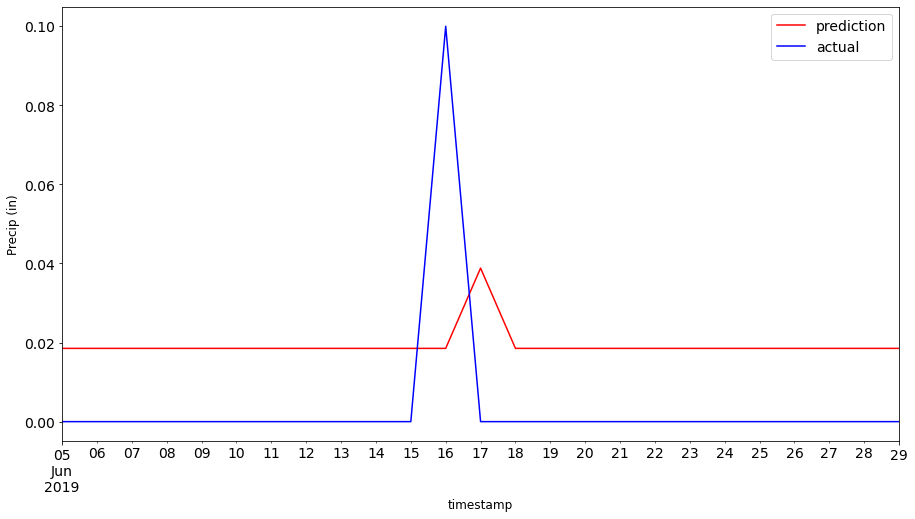

In [ ]:
eval_df[eval_df.timestamp<'12-08-2019'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel(col_target, fontsize=12)
plt.show()

##PREDICTIONS

In [ ]:
predictions = scaler.inverse_transform(predictions)
df2[col_target]=predictions[:,0]

In [ ]:
#Choix de la colonne prédite
cols = list(df.columns)
n_cols = df.shape[1]
col_target=cols[9]

In [ ]:
df2

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles)
0,0.068119,0.006469,558.190552,9.745342,81.798103,45.863811,68.376968,74.855515,21.519608,40.706032,36.751202,3.135957,77.266243
1,0.078214,0.006469,623.057861,8.848877,80.020042,45.356064,67.208672,73.895157,20.259943,38.538910,34.956760,3.783899,89.197182
2,0.057840,0.006469,488.622711,7.099729,77.489868,47.303005,64.081123,69.726173,19.421150,34.163399,30.906616,3.609510,86.519691
3,0.078214,0.006469,697.362366,5.256821,75.073257,42.786732,60.703754,62.661095,18.583342,28.254404,25.009367,4.003155,93.413277
4,0.070662,0.006469,651.310242,6.393015,76.548889,35.494049,60.074135,73.895157,19.421150,35.627712,29.023981,2.840338,71.817139
5,0.073192,0.006469,659.976318,7.942929,81.444489,40.770836,65.177589,72.613518,18.583342,37.086304,33.044876,2.715264,69.039505
6,0.078214,0.006469,666.466919,8.292385,82.050064,45.863811,68.221352,69.405128,19.002117,34.896255,33.736668,2.966412,73.873528
7,0.080703,0.006469,674.389038,9.401775,82.652672,48.016129,71.632294,70.689079,19.421150,35.627712,36.066391,3.135957,77.432823
8,0.080703,0.006469,654.200317,9.539393,81.343269,47.159859,69.852684,71.009964,20.259943,37.813374,36.277287,3.436196,82.539413
9,0.075710,0.006469,647.695374,10.155444,81.596161,47.802647,68.299164,71.330788,21.519608,42.142544,37.434364,2.840338,71.452827


In [ ]:
df2.to_csv('Predictions_Bishop.csv')

##RNN TOUTES LES FEATURES, tableau dupliqué

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyoff
import xgboost as xgb
import seaborn as sns
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

df = pd.read_csv('data/df_condition.csv')
df=df.rename(columns ={'CIMIS Region':'Region', 'Stn Name':'Name'})
df=df[df.Name == 'FivePoints']
ligne_9sept = df.iloc[8]
ligne_9sept['Date']='1/9/2018'
ligne_31mars=df.iloc[87]
ligne_31mars['Date']='3/31/2018'
df=df.append(ligne_9sept)
df=df.append(ligne_31mars)

df2=pd.DataFrame()
for i in range(0,len(df)):
  ligne1=df.iloc[i]
  ligne2=df.iloc[i]
  ligne3=df.iloc[i]
  ligne1['Date']=df.iloc[i]['Date']+' 00:00:00'
  ligne2['Date']=df.iloc[i]['Date']+' 08:00:00'
  ligne3['Date']=df.iloc[i]['Date']+' 16:00:00'
  df2=df2.append(ligne1)
  df2=df2.append(ligne2)
  df2=df2.append(ligne3)
df2.drop(['Unnamed: 0', 'Stn Id','Target','Name','Region'], axis=1, inplace=True)
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%Y %H:%M:%S')
df2=df2.sort_values(by='Date')
df2.set_index('Date', inplace=True)
df2 = df2.rename_axis(None)

#Separation des données pour le test et pour le train
valid_start_dt = '2019-07-15'
test_start_dt = '2019-08-05'

T = 6
HORIZON = 1

#Choix de la colonne prédite
cols = list(df2.columns)
n_cols = df2.shape[1]
for i in range (0,n_cols):
  col_target=cols[i]

# Create training dataset 
  df2[df2.index < valid_start_dt][[col_target]].rename(columns={col_target:'train'}) \
    .join(df2[(df2.index >=valid_start_dt) & (df2.index < test_start_dt)][[col_target]] \
            .rename(columns={col_target:'validation'}), how='outer') \
     .join(df2[test_start_dt:][[col_target]].rename(columns={col_target:'test'}), how='outer') \
      .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
  plt.xlabel('timestamp', fontsize=12)
  plt.ylabel(col_target, fontsize=12)
  plt.show()

  # 1. Get the train data from the correct data range
  train = df2.copy()[df2.index < valid_start_dt][[col_target]]

  # 2. Scale data to be in range (0, 1). 
  #   This transformation should be calibrated on the training set only. 
  #   This is to prevent information from the validation or test sets 
  #   leaking into the training data.
  scaler = MinMaxScaler()
  train[col_target] = scaler.fit_transform(train)

  # 3. Shift the dataframe to create the input samples.
  train_shifted = train.copy()
  train_shifted['y_t+1'] = train_shifted[col_target].shift(-1, freq='d')
  for t in range(1, T+1):
      train_shifted[str(T-t)] = train_shifted[col_target].shift(T-t, freq='d')
  y_col = 'y_t+1'
  X_cols = [col_target+' t-5',
             col_target+' t-4',
             col_target+' t-3',
             col_target+' t-2',
             col_target+' t-1',
             col_target+' t']
  train_shifted.columns = [col_target+'_original']+[y_col]+X_cols

  # 4.Discard any samples with missing values
  train_shifted = train_shifted.dropna(how='any')

  # 5.Transform this Pandas dataframe into a numpy array
  y_train = train_shifted[y_col].to_numpy()
  X_train = train_shifted[X_cols].to_numpy()

  # This is an important step to reshape the X into 3 dimension array
  X_train = X_train.reshape(X_train.shape[0], T, 1)

  # 1. Get the validation data from the correct data range
  look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
  valid = df2.copy()[(df2.index >=look_back_dt) & (df2.index < test_start_dt)][[col_target]]

  # 2. Scale the series using the transformer fitted on the training set:
  valid[col_target] = scaler.transform(valid)

  # 3. Shift the dataframe to create the input samples
  valid_shifted = valid.copy()
  valid_shifted['y+1'] = valid_shifted[col_target].shift(-1, freq='d')
  for t in range(1, T+1):
      valid_shifted[col_target+'_t-'+str(T-t)] = valid_shifted[col_target].shift(T-t, freq='d')
    
  # 4.Discard any samples with missing values
  valid_shifted = valid_shifted.dropna(how='any')

  # 5.Transform this Pandas dataframe into a numpy array
  y_valid = valid_shifted['y+1'].to_numpy()
  X_valid = valid_shifted[[col_target+'_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
  X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

  FIRST_LAYER_LATENT_DIM = 8 # number of units in the RNN layer
  SECOND_LAYER_LATENT_DIM = 6
  BATCH_SIZE = 32 # number of samples per mini-batch
  EPOCHS = 10 # maximum number of times the training algorithm will cycle through all samples

  model = Sequential()
  model.add(GRU(FIRST_LAYER_LATENT_DIM, input_shape=(T, 1)))
  model.add(Dense(SECOND_LAYER_LATENT_DIM))
  model.add(Dense(HORIZON))

  model.compile(optimizer='RMSprop', loss='mse')
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

  history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(X_valid, y_valid),
                      callbacks=[earlystop],
                      verbose=1)

  # 1. Get the test data from the correct data range
  look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
  test = df2.copy()[test_start_dt:][[col_target]]

  # 2. Scale the data
  test[col_target] = scaler.transform(test)

  # 3. Shift the dataframe to create the input samples
  test_shifted = test.copy()
  test_shifted['y_t+1'] = test_shifted[col_target].shift(-1, freq='d')
  for t in range(1, T+1):
      test_shifted[col_target+'_t-'+str(T-t)] = test_shifted[col_target].shift(T-t, freq='d')

  # 4.Discard any samples with missing values
  test_shifted = test_shifted.dropna(how='any')

  # 5.Transform this Pandas dataframe into a numpy array
  y_test = test_shifted['y_t+1'].to_numpy()
  X_test = test_shifted[[col_target+'_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
  X_test = X_test.reshape(X_test.shape[0], T, 1)

  predictions = model.predict(X_test)

eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='d')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

AttributeError: ignored

In [ ]:
history.summary()

NameError: ignored

##CNN Une feature, tableau dupliqué

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Projet-ML')

%cd gdrive/My Drive/Projet-ML

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyoff
import xgboost as xgb
import seaborn as sns
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, Conv1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings  # Des warnings qui me fatiguent
warnings.filterwarnings("ignore")

from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

df = pd.read_csv('data/df_condition.csv')
df=df.rename(columns ={'CIMIS Region':'Region', 'Stn Name':'Name'})
df=df[df.Name == 'Bishop']
ligne_9sept = df.iloc[0]
ligne_9sept['Date']='1/9/2018'
ligne_31mars=df.iloc[87]
ligne_31mars['Date']='3/31/2018'
df=df.append(ligne_9sept)
df=df.append(ligne_31mars)


df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df=df.sort_values(by='Date')
df.set_index('Date', inplace=True)
df = df.rename_axis(None)
df.drop(['Unnamed: 0', 'Stn Id','Target','Name','Region'], axis=1, inplace=True)
df=df.dropna()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Projet-ML'
/content/gdrive/.shortcut-targets-by-id/1E5BC4xrai-P7Q7GdxY5sJ6BpEzTC8crL/Projet-ML


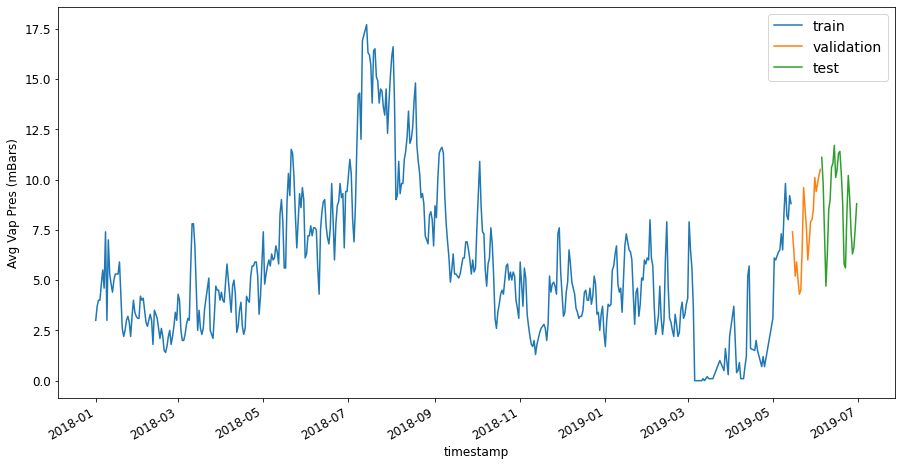

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 0.1151 - val_loss: 0.1199
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0609 - val_loss: 0.0497
Epoch 3/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.0151
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.0150
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0190
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0166
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.0161
Epoch 9/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0158


In [ ]:
#Separation des données pour le test et pour le train
valid_start_dt = '2019-05-15'
test_start_dt = '2019-06-05'

T = 6
HORIZON = 1

#Choix de la colonne prédite
cols = list(df.columns)
n_cols = df.shape[1]
col_target=cols[3]

# Create training dataset 
df[df.index < valid_start_dt][[col_target]].rename(columns={col_target:'train'}) \
  .join(df[(df.index >=valid_start_dt) & (df.index < test_start_dt)][[col_target]] \
          .rename(columns={col_target:'validation'}), how='outer') \
  .join(df[test_start_dt:][[col_target]].rename(columns={col_target:'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel(col_target, fontsize=12)
plt.show()

# 1. Get the train data from the correct data range
train = df.copy()[df.index < valid_start_dt][[col_target]]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train[col_target] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted[col_target].shift(-1, freq='d')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted[col_target].shift(T-t, freq='d')
y_col = 'y_t+1'
X_cols = [col_target+' t-5',
          col_target+' t-4',
          col_target+' t-3',
          col_target+' t-2',
          col_target+' t-1',
          col_target+' t']
train_shifted.columns = [col_target+'_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[col_target]]

# 2. Scale the series using the transformer fitted on the training set:
valid[col_target] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted[col_target].shift(-1, freq='d')
for t in range(1, T+1):
    valid_shifted[col_target+'_t-'+str(T-t)] = valid_shifted[col_target].shift(T-t, freq='d')
  
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[[col_target+'_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

LATENT_DIM = 12
KERNEL_SIZE = 4
BATCH_SIZE = 32
EPOCHS = 10

model = Sequential()
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 1)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))

model.compile(optimizer='Adam', loss='mse')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d') - dt.timedelta(days=T-1)
test = df.copy()[test_start_dt:][[col_target]]

# 2. Scale the data
test[col_target] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted[col_target].shift(-1, freq='d')
for t in range(1, T+1):
    test_shifted[col_target+'_t-'+str(T-t)] = test_shifted[col_target].shift(T-t, freq='d')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[[col_target+'_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)

predictions = model.predict(X_test)

eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='d')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

# %load -s mape common/utils.py
def mape(predictions, actuals):
  """Mean absolute percentage error"""
  return ((predictions - actuals).abs() / actuals).mean()

In [ ]:
mape(eval_df['prediction'], eval_df['actual'])

0.21713491625251632

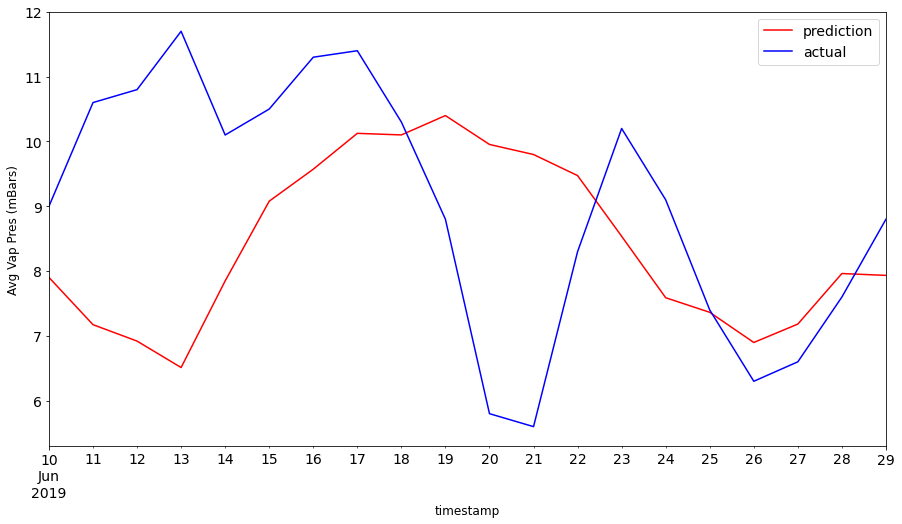

In [ ]:
eval_df[eval_df.timestamp<'12-08-2019'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel(col_target, fontsize=12)
plt.show()